In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
calc_temps_year = calc_temps("2016-08-23", "2017-08-23")
calc_temps_year

[(58.0, 74.59058295964125, 87.0)]

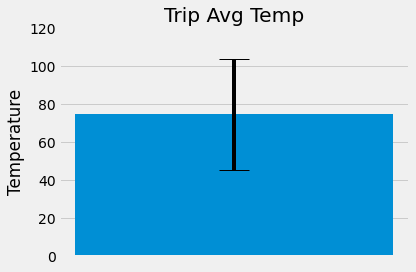

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1,calc_temps_year[0][1], yerr=calc_temps_year[0][2]-calc_temps_year[0][0], capsize=15)
plt.title("Trip Avg Temp")
plt.ylim(0, 120, 10)
plt.ylabel("Temperature")
plt.xticks([])
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station = pd.read_sql('''select s.station, s.name, s.latitude, s.longitude, s.elevation, sum(m.prcp) as rainfall_year
                              from Station s
                              join Measurement m on s.station=m.station
                              where m.date between '2016-08-23' and '2017-08-23' 
                              group by s.station
                              order by rainfall_year desc''', conn)
rain_station

,station,name,latitude,longitude,elevation,rainfall_year
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


In [46]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [137]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
days = ('08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07')

normals=[]
for day in days:
    normals = daily_normals(day)[0]
normals

(71.0, 77.15686274509804, 83.0)

In [139]:
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(start=start_date, end=end_date)
range_dates

# Strip off the year and save a list of strings in the format %m-%d
dates = []
for days in range_dates:
    day = dt.datetime.strftime(days, '%m-%d')
    dates.append(day)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in dates:
    dailynormals = daily_normals(date)[0]
    normals.append(dailynormals)
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [143]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
daily_normals_df["trip_dates"] = dates
daily_normals_df = daily_normals_df.set_index("trip_dates")
daily_normals_df

,tmin,tavg,tmax
trip_dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


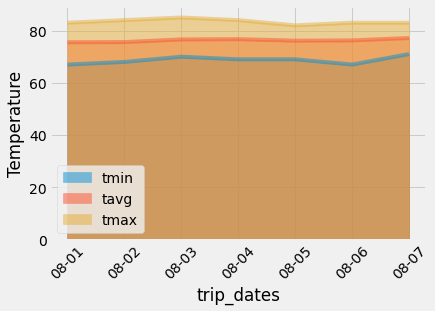

In [147]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, title="")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.show()

## Close Session

In [148]:
session.close()